# Building Decision Tree Models

A decision tree is basically a flow chart where the graph takes the form of a tree. Decision tree models are attractive because of their high interpretability and speed. Fitting a decision tree on data involves making two decisions – 1) Deciding when to branch (splitting criterion) 2) Deciding when to stop (stopping criterion). These two decisions determine the depth and width of the tree.

In this example, we will first fit a simple decision tree and then explore its variations namely Bagging, Random Forests, and Boosting. The goal is to understand their differences and learn where they are best applicable. We will do this in a structured manner, following the "data science process" (Fig 1). 

<img src="images/data-science-process.jpg" width="40%">

The question we are trying to answer is: **whether we can accurately predict heart disease status by measuring maximum heart rate and serum cholesterol levels.**

##### Steps involved:

1. We begin with an exploratory data analysis (EDA) to understand the data better. As the flow chart mentions, the objective of this exercise is to unearth the peculiarities of underlying data which might tell us which models are appropriate. 

2. Next, we will set a performance benchmark for our models based on the data and the nature of the problem at hand. This is necessary because we need to evaluate the models we train in a consistent manner.

2. Then, we train different models on the training set. In this process, we will also tune their hyperparameters using cross-validation. 

3. Finally, we will compare the performance of our models on our testing set and choose the one that meets our needs. 

In [2]:
#First, let's import  required libraries
#pandas and numpy for data manipulation; sklearn for model building and anlysis; matplotlib and mlxtend for visualization
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import plot_decision_regions

- Tip: I usually do not use many third-party libraries beyond the standard ones, because I like to build my own functions when I need them. This is good practice because it helps us learn better and reduces dependencies. But sometimes, it can also be time-consuming, especially if you are more interested in the results rather than the process. That is why I used mlxtend package to visualize decision boundary here instead of building it from scratch (which is done using numpy's meshgrid() in case you are interested)

### Exploratory data analysis

Using machine learning for medical diagnosis is tricky for a number of reasons:

1. Datasets are small because collecting data is expensive.
2. Datasets are usually highly imbalanced i.e. there are far fewer positive cases compared to the negatives. In such as sitauation, a model can deliver good performance on the test set just by being biased towards one category while classifying. Such models may not perform well in the real world.
3. False negatives are far more costly than false positives. This is because a false positive automatically triggers further diagnosis, while a false negative allows the condition to deteriorate in the absence of treatment. 

Therefore, EDA becomes even more important.

In [3]:
#Read train and test datasets
traindf = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")

In [4]:
#Take a look at the contents of traindf
traindf.head()

,thalach,chol,num
0,150.0,233.0,0
1,108.0,286.0,1
2,129.0,229.0,1
3,187.0,250.0,0
4,172.0,204.0,0


In [5]:
traindf.dtypes

thalach    float64
chol       float64
num          int64
dtype: object

In [6]:
#Convert train and test dataframes into X,y numpy arrays
X_train = traindf.values[:,:-1]
y_train = traindf.values[:,-1]

X_test = testdf.values[:,:-1]
y_test = testdf.values[:,-1]

In [7]:
X_train.shape

(228, 2)

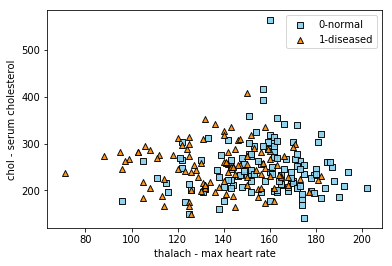

In [8]:
#Visualize training data on a scatter plot
plt.scatter(X_train[y_train==0,0],X_train[y_train==0,1], c='skyblue', marker= 's', edgecolors='k', alpha =0.9, label = '0-normal')
plt.scatter(X_train[y_train==1,0],X_train[y_train==1,1], c='darkorange', marker= '^', edgecolors='k', alpha =0.9, label = '1-diseased')

plt.legend()
plt.xlabel("thalach - max heart rate")
plt.ylabel("chol - serum cholesterol")
plt.savefig("images/eda.png")
plt.show()

There are two things to note in the scatter plot. 

1. The data is widely spread out. This indicates that the predictors we chose are probably not the best determinants of heart disease. Ideally, we would deal with this either by reducing dimensionality (PCA) or by including more predictors (based on domain knowledge or by using more structured feature selection methods such as forward/backward selection). Let's ignore this step for the time being and restrict ourselves to the two predictors at hand for the sake of simplicity.

2. The decision boundary is not a continuous curve. Therefore, conventional multilinear or logistic regression methods are unlikely to give the best results. Therefore, exploring decision tree models is a reasonable way forward.

3. There aren't many outliers. It is important to be mindful of outliers because some models are greatly influenced by them. However, decision trees are not greatly influenced by outliers and therefore not a matter of concern for now.

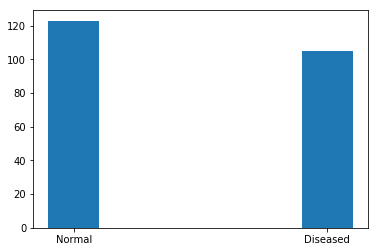

Proportion of diseased cases: 0.46


In [39]:
#Check how balanced the training set is
unique_classes,counts = np.unique(y_train,return_counts = True)
class_names = ["Normal","Diseased"]


plt.bar(class_names, counts, width = 0.2)
plt.show()

print("Proportion of diseased cases: {}".format(round(counts[1]/len(y_train),2)))

The dataset is balanced since diseased cases make up 46% of the cases. 

This information is also useful for helping us set a performance benchmark. One one hand, a purely random model which classifies a case as "diseased" or "normal" based on the toss of an unbiased coin can deliver an expected classification accuracy of 50% (since there are only two classes). On the other hand, a model which classifies every case as "normal" will also deliver an accuracy ~55% on the training set. Therefore, the model we build needs to beat these values at the very least. 

In this case, we define the metric for model performance as classification accuracy on the test set. Let us first build functions for measuring performance and to visualize decision boundary.

In [40]:
#Function to get test accuracy
def accuracy(X, y, model):
    return round(accuracy_score(y,model.predict(X)),2)

In [41]:
#function to plot decision boundary
def plot_regions(X,y,model,ax,title):
    plt.sca(ax)
    plot_decision_regions(X=X, y=y.astype(np.integer), clf=model, legend =2)
    
    plt.title(title)
    plt.xlabel("thalach")
    plt.ylabel("cols")


### Building models

Let us look at how decision trees are built for classification problems without getting too much into the details. 

Say the dataset has 'j' predictors and 'k' classes. To build a decision tree, we need a loss function which will 
determine whether a branching pattern is optimal. This is the splitting criterion - which is usually either the classification error, Gini index, or entropy. The stopping criterion prevents the model from overfitting on the data. This can be a heuristic based on maximum depth or a minimum threshold of information gain. The pseudo-code for building a decision tree is as follows:

- At a given depth, choose the predictor and the value to construct a new branch such that the loss function in the resultant regions is the minimum
- Once the branch is made, check if the stopping criterion is reached. 
- If yes, then the tree is complete. If no, then repeat from beginning.

Let us now go ahead and build the models.

#### 1. A simple decision tree

- We will use a pipeline to build the model. Pipelines are a good way to ensure that any preprocessing that we do on the data (like standardization in this example) are replicable. Pipelines make it easier for models to be deployed into at a later stage.

In [42]:
#Build a pipeline
tree_steps = [('standardizer', StandardScaler()),('tree', DecisionTreeClassifier(random_state =42))]
tree_pipe = Pipeline(tree_steps)

- To learn more about why we need to set the random_state, check this out: https://stackoverflow.com/questions/39158003/confused-about-random-state-in-decision-tree-of-scikit-learn

- Maximum depth is a parameter which determines the extent of bias-variance tradeoff for decision trees. In order to find the best parameter, we will tune it using a straightforward gird search optimization algorithm combined with crossvalidation.

In [43]:
#define tree params - max depth of 2 to 20
tree_params = {"tree__max_depth":list(range(2,20))}

In [44]:
tree = GridSearchCV(tree_pipe,param_grid = tree_params, cv=5, scoring = "accuracy")
tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tree__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [45]:
tree.best_params_

{'tree__max_depth': 2}

In [46]:
print("Training accuracy is: {}".format(accuracy(X_train, y_train,tree)))
print("Testing accuracy is: {}".format(accuracy(X_test, y_test,tree))) 

Training accuracy is: 0.7
Testing accuracy is: 0.71


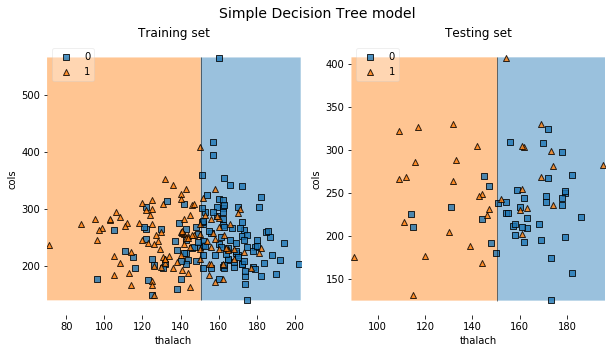

In [47]:
fig, ax = plt.subplots(1,2, figsize = (10, 5))
plot_regions(X_train,y_train, tree,ax[0], "Training set")
plot_regions(X_test,y_test, tree,ax[1], "Testing set")

fig.suptitle("Simple Decision Tree model", fontsize=14)
plt.savefig("images/simpletree.png")
plt.show()

**Result:** It turns out that the best simple decision tree turns out to be the one with just two branches. While the 70% accuracy on the training set is not spectacular, it is good that it maintains the same performance on the test set.

### 2. Ensemble methods

The three models that we will build next, namely bagging, random forests, and boosting, are ensemble models. The basic idea behind ensemble models is to combine multiple models in such a way that the combined performance is better than each of them separately. 

These three decision tree-based ensemble models improve performance in different ways. Let us explore each of them separately.

### 2.1 Bagging

Bagging is a portmanteau work for "bootstrap aggregating". The idea behind bagging is to generate multiple bootstrap samples of the same size as the given data, train separate decision tree on each sample, and average the output from each tree to make the final classification. 

Theoretically, that advantages of bagging are 1) complex decision boundaries can be modelled since there are multiple trees 2) low variance because the output is averaged

In [48]:
#Build a bagging pipeline
bag_steps = [('standardizer', StandardScaler()),('bag', BaggingClassifier(random_state=42))]
bag_pipe = Pipeline(bag_steps)

- The hyperparameter in bagging is the number of trees that we want to build. We will tune this paramter using cross-validation.

In [49]:
#Hyper-parameter tuning
#n-estimators == no. of trees
bag_params = {"bag__n_estimators":list(range(2,11))}
bag = GridSearchCV(bag_pipe,param_grid = bag_params, cv=5, scoring = "accuracy")
bag.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('bag', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
         verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bag__n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [50]:
bag.best_params_

{'bag__n_estimators': 5}

In [51]:
print("Training accuracy is: {}".format(accuracy(X_train, y_train,bag)))
print("Testing accuracy is: {}".format(accuracy(X_test, y_test,bag))) 

Training accuracy is: 0.95
Testing accuracy is: 0.63


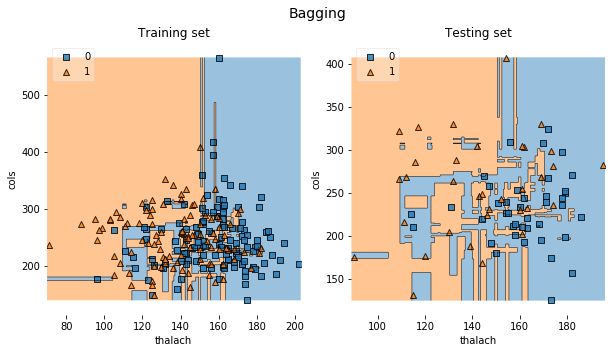

In [52]:
fig, ax = plt.subplots(1,2, figsize = (10, 5))
plot_regions(X_train,y_train, bag,ax[0], "Training set")
plot_regions(X_test,y_test, bag,ax[1], "Testing set")

fig.suptitle("Bagging", fontsize=14)
plt.savefig("images/bag.png")
plt.show()

**Result:** There are two important things to note:
- Firstly, while the model performs amazingly well on the training set by delivering an accuracy of 95%, it performs poorly on the test set. This is because the complex decision boundary that bagging produces overfits on the training set. This is counterintuitive. **why did bagging reduce accuracy?**
- Secondly, the model is no longer interpretable. This is a drawback that bagging shares with other ensemble methods as well.

### 2.2. Random Forest

A Random Forest is a variation of bagging. The variance reduction in bagging is not efficient because the trees are strongly correlated. Random forests overcome this problem by de-correlating the trees in the ensemble. This is done by randomly choosing a subset of features to decide each split instead of using the entire feature set.

In [53]:
rf_steps = [('standardizer', StandardScaler()),('rf', RandomForestClassifier(random_state=42))]
rf_pipe = Pipeline(rf_steps)

In [54]:
rf_params = {"rf__n_estimators":list(range(2,11))}
rf = GridSearchCV(rf_pipe,param_grid = rf_params, cv=5)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_de...timators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rf__n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [55]:
rf.best_params_

{'rf__n_estimators': 2}

In [56]:
print("Training accuracy is: {}".format(accuracy(X_train, y_train,rf)))
print("Testing accuracy is: {}".format(accuracy(X_test, y_test,rf))) 

Training accuracy is: 0.86
Testing accuracy is: 0.6


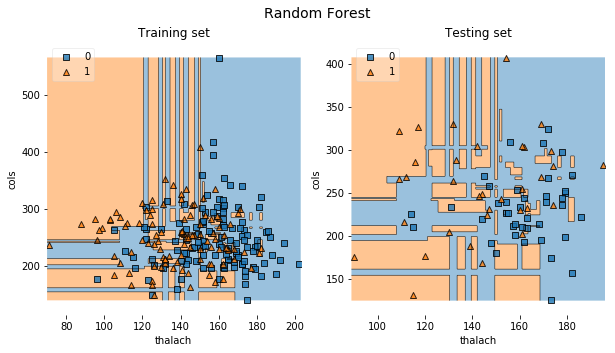

In [57]:
fig, ax = plt.subplots(1,2, figsize = (10, 5))
plot_regions(X_train,y_train, rf,ax[0], "Training set")
plot_regions(X_test,y_test, rf,ax[1], "Testing set")

fig.suptitle("Random Forest", fontsize=14)
plt.savefig("images/rforest.png")
plt.show()

Results:
- Why did RF perform even poorly?

### 2.3. Boosting

Boosting is an ensemble method that is fundamentally different from bagging and random forests. While the latter combines decision trees in parallel, boosting combines models additeively. The ensemble model in boosting is a linear combination of simpler trees. 

There are several variations of boosting. In this example, we use an algorithm called AdaBoost, which stands for Adaptive Boosting. With AdaBoost, the performance of the weak base learner is iteratively improved by training new trees on points that were incorrectly classified. Thus, the complex model at the end of this iterative process deliver higher classification accuracy.

In [58]:
boost_steps = [('standardizer', StandardScaler()),('boost', AdaBoostClassifier(random_state=42))]
boost_pipe = Pipeline(boost_steps)

In [59]:
boost_params = {"boost__n_estimators":list(range(2,11))}
boost = GridSearchCV(boost_pipe,param_grid = boost_params, cv=5)
boost.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('boost', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'boost__n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [60]:
boost.best_params_

{'boost__n_estimators': 2}

In [61]:
print("Training accuracy is: {}".format(accuracy(X_train, y_train,boost)))
print("Testing accuracy is: {}".format(accuracy(X_test, y_test,boost))) 

Training accuracy is: 0.7
Testing accuracy is: 0.71


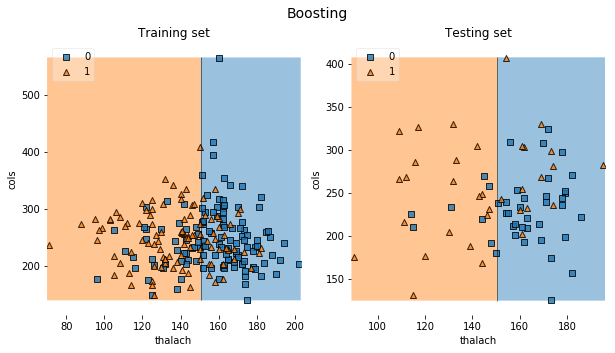

In [62]:
fig, ax = plt.subplots(1,2, figsize = (10, 5))
plot_regions(X_train,y_train, boost,ax[0], "Training set")
plot_regions(X_test,y_test, boost,ax[1], "Testing set")

fig.suptitle("Boosting", fontsize=14)
plt.savefig("images/boost.png")
plt.show()

Boosting did not change anything


#### Deploying the model